# Tesina: The economics behind two-sided markets: key determinants of Airbnb pricing in Mexico City

## Edgar Robles Díaz

### Fuente principal: Inside Airbnb (Murray Cox) /  Trip Advisor / Datos abiertos de la CDMX

### Parte 5. Modelado estadístico

* Selección de matriz de pesos óptima
* Revisión de supuestos (Normalidad, independencia, multicolinealidad y heteroscedasticidad) 
* Regresión tradicional (OLS)
* Autocorrelación espacial (SAR) 
* Errores espaciales (SEM)
* Análisis de residuales
* Estimación de efectos directos, indirectos y totales.

# Importar paquetería esencial

In [487]:
import seaborn as sns
from matplotlib import pyplot as plt 

import pandas as pd 
import numpy as np

import pysal
from pysal.lib import weights
from pysal.lib import cg as geometry
import libpysal
import spreg

import scipy.stats as stats


import statsmodels.stats.api as sms

from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import os

In [490]:
os.getcwd()

'c:\\Users\\edari\\Desktop\\CIDE\\8 Octavo\\SEMINARIO DE TITULACIÓN\\Manejo de Datos\\Código tesina'

In [489]:
os.chdir('c:\\Users\\edari\\Desktop\\CIDE\\8 Octavo\\SEMINARIO DE TITULACIÓN\\Manejo de Datos\\Código tesina')

## Importar datos 

In [492]:
geo_df2 = pd.read_csv('inside_abnb_clean_2.csv', encoding = 'latin1')

In [494]:
geo_df2.set_index('id', inplace=True)

In [502]:
dummies = [
        'host_is_superhost','host_identity_verified',
        'insta_book', 'pets_allowed', 'gym',
        'breakfast', 'washer', 'dryer',
        'parking', 'Private room', 
        'flexible_cancel', 'Tipo Listado', 
        'elevator', 'hot_tub',
        'smoking_allowed', 'pool'
          ]

for dum in dummies:
    geo_df2[dum] = geo_df2[dum].astype('category')

In [508]:
geo_df2['geometry'] = list(zip(geo_df2.longitude, geo_df2.latitude))
geo_df2['geometry'] = geo_df2['geometry'].apply(Point)
geo_df2 = gpd.GeoDataFrame(geo_df2, geometry='geometry')

### Selección de variables explicativas para el modelo ###

In [512]:
x_clean = geo_df2[[  
    
                 ### Tamaño y características físicas  ###
                    'bedrooms', 'bathrooms', 'accommodates',
                 ### Características listado ###
                    'insta_book', 'ad_duration',
                 ### Ubicación  #### 
                    'pi_dist', 'metro_distance',
                 ### Amenidades #### 
                    'parking', 'breakfast', 'gym', 'pool', 'hot_tub', 'elevator', 'washer','dryer',
                 ### Reglas ### 
                    'flexible_cancel', 'pets_allowed', 'smoking_allowed',
                  
                 ### Características anfitrión ### 
                    'host_is_superhost', 'Tipo Listado', 'host_identity_verified',
                  
                  ### Reputación ###
                  'review_scores_rating', 'number_of_reviews']]

### VIF - Test de multicolinealidad

In [514]:
x = add_constant(x_clean)

In [515]:
pd.Series([variance_inflation_factor(x.values, i) 
               for i in range(x.shape[1])], 
              index=x.columns)

const                     230.060101
bedrooms                    2.228837
bathrooms                   1.769685
accommodates                2.343871
insta_book                  1.059943
ad_duration                 1.894577
pi_dist                     1.280073
metro_distance              1.225382
parking                     1.114100
breakfast                   1.019611
gym                         1.852181
pool                        1.939207
hot_tub                     1.373703
elevator                    1.318304
washer                      1.173956
dryer                       1.250643
flexible_cancel             1.164661
pets_allowed                1.068588
smoking_allowed             1.081812
host_is_superhost           1.197603
Tipo Listado                1.081068
host_identity_verified      1.166855
review_scores_rating        1.097658
number_of_reviews           1.841674
dtype: float64

Ninguna de las explicativas supera el valor de 10, por lo tanto no hay multicolinealidad entre los estimadores de Airbnb y de TripAdvisor

### Modelo SEM:

## $y\ =\ \alpha\ +\ X\beta\ +\ {(I\ -\ \lambda W)}^{-1}\varepsilon\$ 

### Modelo SAR:

## $y\ =\ \alpha\ +\ \rho Wy\ +\ X\beta\ +\ \varepsilon$

Donde Y el vector que representa a la variable dependiente, el vector X representa a las variables explicativas y el vector B a los coeficientes asociados a las variables explicativas. 

Adicionalmente, el modelo de autocorrelación espacial (SAR) incorpora elementos adicionales. La matriz W se puede interpretar como la relación que existe entre las observaciones y sus respectivos vecinos. En este sentido, la variable Wy representa una función de la variable dependiente de los puntos cercanos de cada observación.

El coeficiente p indica el grado de influencia que tienen los valores de los vecinos sobre la variable dependiente de cada observación. Si el coeficiente es alto y significativo, es posible que exista un efecto spillover y, en consecuencia, un efecto espacial entre las observaciones y su respectiva vecindad.

In [534]:
w35 = libpysal.weights.KNN.from_dataframe(geo_df2, k=35)

In [535]:
w35.transform = 'V'

### Seleccionar matriz de pesos óptima para el modelo (Mayor R$^2$ y menor AIC) (Chica-Olmo et al. 2020)

In [ ]:
### Generar matrices de pesos con diferentes números de vecinos más cercanos ###

In [518]:
k = [10, 15,20,25,30,35,40,45,50,55,60,65,70,75,80]

In [519]:
mats= [libpysal.weights.KNN.from_dataframe(geo_df2, 
                                           k=i)
      for i in k ]

In [520]:
for w in mats:
    w.transform = 'V'

In [ ]:
### Estimar modelos con ML_Lag###

In [527]:
knn_models_ml =[ spreg.ML_Lag(geo_df2['ln_price'].values[:,None],
                 x_clean.values,
                 w = w,
                 method='ord',
                 spat_diag=True,
                 name_x=x_clean.columns.tolist(),
                 name_y='ln(price)')
for w in mats
               ]

C:\Users\edari\anaconda3\envs\Tesis\lib\site-packages\scipy\optimize\_minimize.py:777: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
C:\Users\edari\anaconda3\envs\Tesis\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [539]:
### Extraer AIC y R2

In [528]:
ml_r_sq = [ml.pr2 for ml in knn_models_ml]

In [529]:
ml_aic = [ml.aic for ml in knn_models_ml]

In [530]:
sns.set_style('whitegrid')

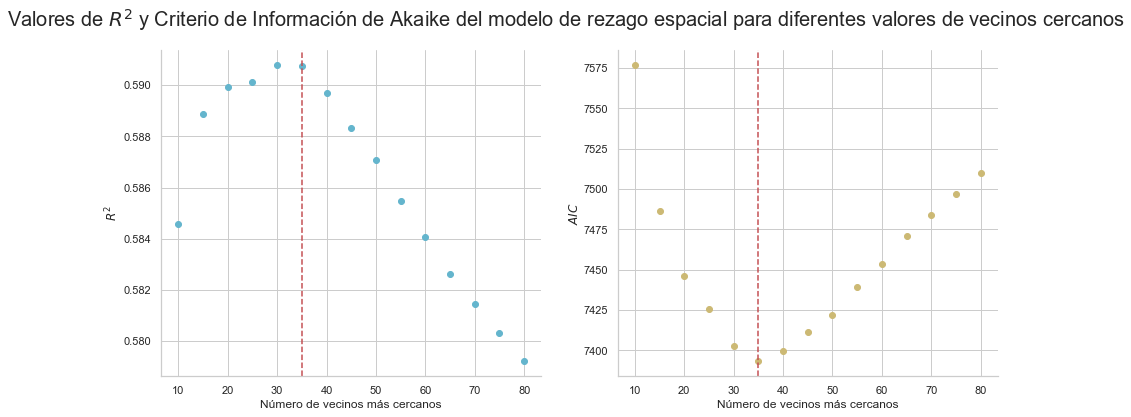

In [532]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Valores de $R^2$ y Criterio de Información de Akaike del modelo de rezago espacial para diferentes valores de vecinos cercanos', fontsize=20)
fig.set_figheight(6)
fig.set_figwidth(15)
ax1.scatter(k, r_sq,c = 'c')
ax1.axvline(x=35,c='r', linestyle='--')
ax2.axvline(x=35,c='r', linestyle='--')
ax1.yaxis.set_label_text('$R^2$')
ax2.yaxis.set_label_text('$AIC$')
ax1.xaxis.set_label_text('Número de vecinos más cercanos')
ax2.xaxis.set_label_text('Número de vecinos más cercanos')
ax2.scatter(k, ml_aic, c='y')
sns.despine()
plt.savefig('RAIC.png')

### Selección matriz de 35 vecinos más cercanos

In [542]:
w35 = mats[5]

### Modelo OLS para valuar supuestos de normalidad en los errores (Jarque-Bera) e independencia de las observaciones, selección de modelo espacial (SAR -LM LAg, SEM -LM Error)

### MCO tradicional

In [ ]:
### Insertar matriz de varianza-covarianza de White para controlar la heteroscedasticidad  

In [550]:
m_test_ols = spreg.OLS(geo_df2['ln_price'].values[:,None], x_clean.values,robust='white' ,moran=True, w = w35, spat_diag = True ,name_x = x_clean.columns.tolist(), name_y='(log)price')

In [551]:
print(m_test_ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :  (log)price                Number of Observations:        6131
Mean dependent var  :      6.6858                Number of Variables   :          24
S.D. dependent var  :      0.6823                Degrees of Freedom    :        6107
R-squared           :      0.4642
Adjusted R-squared  :      0.4622
Sum squared residual:    1528.787                F-statistic           :    230.0685
Sigma-square        :       0.250                Prob(F-statistic)     :           0
S.E. of regression  :       0.500                Log likelihood        :   -4441.890
Sigma-square ML     :       0.249                Akaike info criterion :    8931.780
S.E of regression ML:      0.4994                Schwarz criterion     :    9093.086

White Standard Errors
-------------------------------------------------------

# Aplicar modelos Autocorrelación espacial y errores espaciales (SAR y SEM)

# SAR (ML)

In [543]:
ML_mk45 = spreg.ML_Lag(geo_df2['ln_price'].values[:,None], x_clean.values, w = w35,  method='ord',spat_diag=True, name_x=x_clean.columns.tolist(), name_y='ln(price)')


C:\Users\edari\anaconda3\envs\Tesis\lib\site-packages\scipy\optimize\_minimize.py:777: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
C:\Users\edari\anaconda3\envs\Tesis\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [545]:
print(ML_mk45.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = ORD)
----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   ln(price)                Number of Observations:        6131
Mean dependent var  :      6.6858                Number of Variables   :          25
S.D. dependent var  :      0.6823                Degrees of Freedom    :        6106
Pseudo R-squared    :      0.5903
Spatial Pseudo R-squared:  0.5007
Sigma-square ML     :       0.191                Log likelihood        :   -3671.582
S.E of regression   :       0.437                Akaike info criterion :    7393.163
                                                 Schwarz criterion     :    7561.191

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-------------------------------

# SEM (ML)

In [544]:
ML_err_mk45 = spreg.ML_Error(y=geo_df2['ln_price'].values[:,None], x=x_clean.values, w = w35,  method='ord',spat_diag=True, name_x=x_clean.columns.tolist(), name_y='ln(price)')

In [546]:
print(ML_err_mk45.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = ORD)
------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   ln(price)                Number of Observations:        6131
Mean dependent var  :      6.6858                Number of Variables   :          24
S.D. dependent var  :      0.6823                Degrees of Freedom    :        6107
Pseudo R-squared    :      0.4481
Sigma-square ML     :       0.187                Log likelihood        :   -3654.097
S.E of regression   :       0.433                Akaike info criterion :    7356.194
                                                 Schwarz criterion     :    7517.501

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-------------------------------------------------------------

# Análisis residuales 

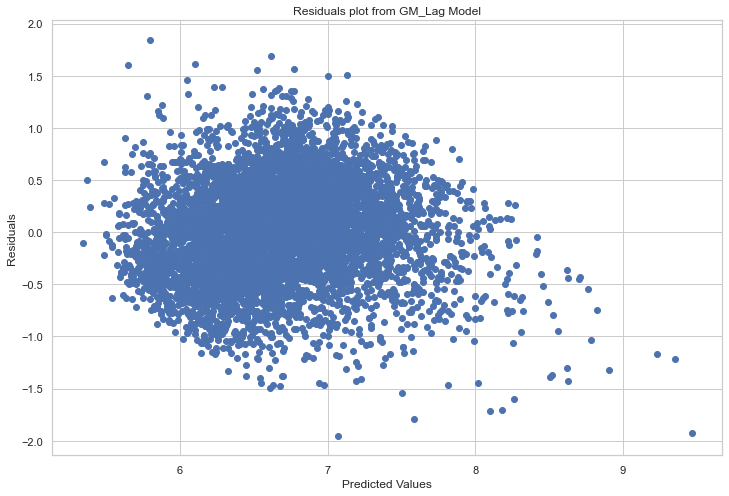

In [547]:
plt.figure(figsize=(12,8))
plt.scatter(ML_mk45.predy, ML_mk45.e_pred); # print resids vs predictions
plt.title("Residuals plot from GM_Lag Model")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.savefig('LR_Residual_Plot')

# Efectos directos, indirectos y totales

In [549]:
b=ML_mk45.betas[:-1]
rho=ML_mk45.betas[-1]
btot=b/(float(1)-rho)
bind=btot-b

full_eff=pd.DataFrame(np.hstack([b,bind,btot]),index=['Constant']+x_clean.columns.tolist(), columns=['Direct','Indirect','Total'])
full_eff

,Direct,Indirect,Total
Constant,1.095394,2.310049,3.405442
bedrooms,0.066660,0.140578,0.207238
bathrooms,0.134923,0.284536,0.419460
accommodates,0.136074,0.286964,0.423038
insta_book,-0.030367,-0.064039,-0.094406
ad_duration,0.002376,0.005010,0.007386
pi_dist,-0.001451,-0.003059,-0.004510
metro_distance,-0.010524,-0.022193,-0.032717
parking,0.023356,0.049255,0.072612
breakfast,0.001873,0.003949,0.005822


### En caso de que no se cumpla el supuesto de normalidad en los errores, aplicar método de momentos, computación más sencilla y robusto a errores no normales.

# SAR (GM) ###

In [425]:
GM_mk45 = spreg.GM_Lag(geo_df2['ln_price'].values[:,None], x_clean.values, w = w45, robust='white' ,spat_diag=True, name_x=x_clean.columns.tolist(), name_y='ln(price)', name_w='KNN weight matrix (k=45)')

C:\Users\edari\anaconda3\envs\Tesis\lib\site-packages\spreg\user_output.py:438: UserWarning: w must be API-compatible pysal weights object
  warn("w must be API-compatible pysal weights object")


# SEM (GM)

In [435]:
GM_err_mk45 = spreg.GM_Error_Het(geo_df2['ln_price'].values[:,None], x_clean.values ,w = w45,name_x=x_clean.columns.tolist(), name_y='ln(price)', name_w='KNN weight matrix (k=45)')

C:\Users\edari\anaconda3\envs\Tesis\lib\site-packages\spreg\user_output.py:438: UserWarning: w must be API-compatible pysal weights object
  warn("w must be API-compatible pysal weights object")
